# Produce lifetime XY map

### Run 5812: stable running conditions
- pressure: 10 bar
- Gate voltage: 8 kV

### Notebook configuration

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 14

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

In [3]:
import os
import time
import collections

import tables            as tb
import numpy             as np


import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string


from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)


In [26]:
from core.kr_types import KrEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import KrMeanAndStd
from core.kr_types import KrLTLimits
from   invisible_cities.evm  .ic_containers  import Measurement

In [8]:
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_fit_functions as krf

In [9]:
from   invisible_cities.core.core_functions import weighted_mean_and_std
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax

In [10]:
print("This notebook has been run on ", time.asctime())

This notebook has been run on  Mon Jun 11 01:52:50 2018


### Files

In [46]:
path = f"/Users/jjgomezcadenas/Projects/ICDEV/kdst"
run_number          = 5812
input_dst_filename  = f"{path}/{run_number}/kdst_{run_number}_s1s2.h5"
output_dst_filename = f"{path}/{run_number}/kdst_{run_number}_map_lt.h5"

print(f"run number = {run_number}")
print(f"input dst = {input_dst_filename}")
print(f"output dst = {output_dst_filename}")

run number = 5812
input dst = /Users/jjgomezcadenas/Projects/ICDEV/kdst/5812/kdst_5812_s1s2.h5
output dst = /Users/jjgomezcadenas/Projects/ICDEV/kdst/5812/kdst_5812_map_lt.h5


### Read data

In [47]:
dst           = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 1272473 
Total number of events: 1272473


In [48]:
X = dst.X  .values
Y = dst.Y  .values
Z = dst.Z  .values
E = dst.S2e.values
Q = dst.S2q.values

krEvent = KrEvent(X = dst.X.values,
                  Y = dst.Y.values,
                  Z = dst.Z.values,
                  E = dst.S2e.values,
                  Q = dst.S2q.values)

### Ranges and binning

In [52]:
Zrange  =  100,  550
XYrange = -200,  200
Erange  =  2e3, 20e3
Qrange  =  100, 1500
Znbins  =   10
XYnbins =   60
Enbins  =  50
Qnbins  =  50

Zbins     = np.linspace(* Zrange,  Znbins + 1)
Ebins     = np.linspace(* Erange,  Enbins + 1)
Qbins     = np.linspace(* Qrange,  Qnbins + 1)
XYbins    = np.linspace(*XYrange, XYnbins + 1)
XYcenters = shift_to_bin_centers(XYbins)
XYpitch   = np.diff(XYbins)[0]

In [53]:
krNBins  = KrNBins(E = Enbins, Q = Qnbins, Z = Znbins, XY = XYnbins)
krRanges = KrRanges(E = Erange, Q = Qrange, Z = Zrange, XY = XYrange)
krBins   = KrBins(E = Ebins, Q = Qbins, Z = Zbins, XY = XYbins, cXY = XYcenters) 

### Event distribution

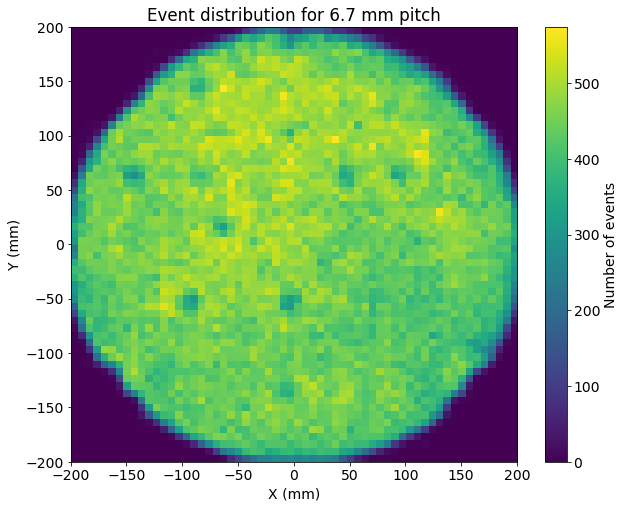

In [54]:
nevt, *_ = plt.hist2d(X, Y, (XYbins, XYbins))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"Event distribution for {XYpitch:.1f} mm pitch")

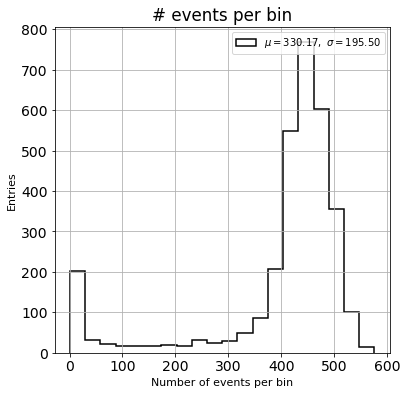

In [55]:
nevt_max = int(np.max(nevt))
mu, sigma = krh.h1d(nevt.flatten(), bins=20, range=(1, nevt_max + 2),
        xlabel='Number of events per bin', ylabel='Entries',
        title="# events per bin", legend = 'upper right',)

### Fit examples

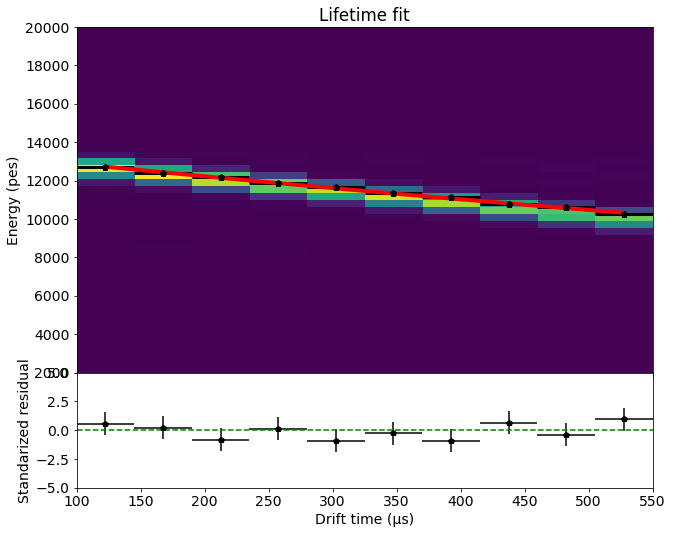

In [56]:
xlim =  -25,  25
ylim = -25, 25
xyr = XYRanges(X=xlim, Y=ylim )

kf = krf.lifetime_in_XYRange(krEvent, krNBins, krBins, krRanges, xyr)

In [19]:
krf.print_fit(kf)

 E (z=0) = 13289.417821534505 +-35.099061291030935 
 LT      = -1966.5893656712542 +-39.28853795022507 
 chi2    = 1.7197810557102229 


### Compute lifetime maps

In [57]:
krfs = krf.fit_lifetime_slices(krEvent, krNBins, krBins, krRanges, fit_var = "E", min_entries=100)

/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/fit_functions.py:135: RuntimeWarning: invalid value encountered in less_equal
  if np.any(sigma_r <= 0):
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [262]:
krfs = krf.fit_slices_2d_expo(krEvent, krNBins, krBins, krRanges, fit_var = "E", min_entries=100)

/Users/jjgomezcadenas/Projects/ICARO/icaro/core/fit_functions.py:85: RuntimeWarning: invalid value encountered in greater
  valid_points = yu > 0
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [58]:
Escale_abs, ELT_abs, Echi2, valid = krfs.Es, krfs.LT, krfs.chi2, krfs.valid  
Escale     = to_relative(Escale_abs, percentual=True)  # errors in %
ELT        = to_relative(ELT_abs, percentual=True)

In [214]:
krfs = krf.fit_slices_2d_expo(krEvent, krNBins, krBins, krRanges, fit_var = "Q", min_entries=1e2)

/Users/jjgomezcadenas/Projects/ICARO/icaro/core/fit_functions.py:85: RuntimeWarning: invalid value encountered in greater
  valid_points = yu > 0
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [183]:
Qscale_abs, QLT_abs, Qchi2, Qok = krfs.Ez0, krfs.LT, krfs.chi2, krfs.valid 

In [333]:
#Escale_abs, ELT_abs, Echi2, Eok = krf.fit_slices_2d_expo(X, Y, Z, E, 
#                                                         XYbins, XYbins, Znbins, 
#                                                         zrange=Zrange, min_entries=1e2)
Eok1        = ELT_abs.value > 100
Eok2        = ELT_abs.value < 4000
Eok        = Eok1 & Eok2
Escale     = to_relative(Escale_abs, percentual=True)  # errors in %
ELT        = to_relative(ELT_abs, percentual=True)

In [185]:
#Qscale_abs, QLT_abs,\
#Qchi2, Qok = krf.fit_slices_2d_expo(X, Y, Z, Q, XYbins, XYbins, Znbins, zrange=Zrange, min_entries=1e2)
Qok        = QLT_abs.value > 100
Qscale     = to_relative(Qscale_abs, percentual=True)
QLT        = to_relative(   QLT_abs, percentual=True)

In [59]:
El = KrMeanAndStd(mu    = np.nanmean(ELT      .value      [valid]),
                  std   = np.nanstd (ELT      .value      [valid]),
                  mu_u  = np.nanmean(ELT      .uncertainty[valid]),
                  std_u = np.nanstd (ELT      .uncertainty[valid]))
Es = KrMeanAndStd(mu    = np.nanmean(Escale   .value      [valid]),
                  std   = np.nanstd (Escale   .value      [valid]),
                  mu_u  = np.nanmean(Escale   .uncertainty[valid]),
                  std_u = np.nanstd (Escale   .uncertainty[valid]))

print(f'Lifetime value           : mu +- std ={El.mu} +- {El.std}')
print(f'Lifetime uncertainty     : mu +- std ={El.mu_u} +- {El.std_u}')
print(f'Energy scale value       : mu +- std ={Es.mu} +- {Es.std}')
print(f'Energy scale uncertainty : mu +- std ={Es.mu_u} +- {Es.std_u}')

Lifetime value           : mu +- std =1518.3177978871681 +- 300.8665500829209
Lifetime uncertainty     : mu +- std =4.943942821671264 +- 5.3104786821841525
Energy scale value       : mu +- std =11614.608899771445 +- 1516.3541234458164
Energy scale uncertainty : mu +- std =1.0081179620958474 +- 1.1077967510465456


In [ ]:
Ql = KrMeanAndStat(mu    = np.nanmean(QLT   .value      [Eok]),
                   std   = np.nanstd (QLT   .value      [Eok]),
                   mu_u  = np.nanmean(QLT   .uncertainty[Eok]),
                   std_u = np.nanstd (QLT   .uncertainty[Eok]))
Qs = KrMeanAndStat(mu    = np.nanmean(Qscale   .value      [Eok]),
                   std   = np.nanstd (Qscale   .value      [Eok]),
                   mu_u  = np.nanmean(Qscale   .uncertainty[Eok]),
                   std_u = np.nanstd (Qscale   .uncertainty[Eok]))

In [ ]:
print(f" Lifetime measured in tracking plane ={Ql}")
print(f" Energy scale in tracking plane ={Qs}")

In [414]:
QLT_mean  = np.nanmean(QLT   .value      [Qok])
QLT_std   = np.nanstd (QLT   .value      [Qok])
QLTu_mean = np.nanmean(QLT   .uncertainty[Qok])
QLTu_std  = np.nanstd (QLT   .uncertainty[Qok])

Q_mean    = np.nanmean(Qscale.value      [Qok])
Q_std     = np.nanstd (Qscale.value      [Qok])
Qu_mean   = np.nanmean(Qscale.uncertainty[Qok])
Qu_std    = np.nanstd (Qscale.uncertainty[Qok])

In [60]:
n_sigma  = 3
u_sigma  = 2
kltl = KrLTLimits(Es  = minmax(Es.mu - n_sigma * Es.std, Es.mu + n_sigma * Es.std),
                  LT  = minmax(El.mu - n_sigma * El.std,El.mu + n_sigma * El.std),
                  Eu  = minmax(max(Es.mu_u - u_sigma * Es.std_u, 1e-3),  
                              Es.mu_u + u_sigma * Es.std_u),
                  LTu = minmax(max(El.mu_u - u_sigma * El.std_u, 1e-3),
                              El.mu_u + u_sigma * El.std_u))
 


print(f" Energy scale (E): E_min = {kltl.Es.min}; E_max = {kltl.Es.max}")
print(f" Lifetime (ELT): ELT_min = {kltl.LT.min}; ELT_max = {kltl.LT.max}")
print(f" Energy scale error (Eu): Eu_min = {kltl.Eu.min}; Eu_max = {kltl.Eu.max}")
print(f" Lifetime error (ELTu): ELTu_min = {kltl.LTu.min}; ELTu_max = {kltl.LTu.max}")

 Energy scale (E): E_min = 7065.546529433996; E_max = 16163.671270108895
 Lifetime (ELT): ELT_min = 615.7181476384053; ELT_max = 2420.917448135931
 Energy scale error (Eu): Eu_min = 0.001; Eu_max = 3.2237114641889386
 Lifetime error (ELTu): ELTu_min = 0.001; ELTu_max = 15.56490018603957


In [ ]:
Q_min    = Qs.mu - n_sigma * Qs.std
Q_max    = Qs.mu + n_sigma * Qs.std

print(f" Energy scale (Q): Q_min = {Q_min}; Q_max = {Q_max}")

QLT_min  = Ql.mu - n_sigma * Ql.std
QLT_max  = Ql.mu + n_sigma * Ql.std

print(f" Lifetime (QLT): QLT_min = {QLT_min}; QLT_max = {QLT_max}")

Qu_min   = max(Qs.mu_u - u_sigma * Qs.std_u, 1e-3)
Qu_max   =     Qs.mu_u + u_sigma * Qs.std_u

print(f" Energy scale error (Qu): Qu_min = {Qu_min}; Qu_max = {Qu_max}")

QLTu_min = max(Ql.mu_u - u_sigma * Ql.std_u, 1e-3)
QLTu_max =     Ql.mu_u + u_sigma * Ql.std_u

print(f" Lifetime error (QLTu): QLTu_min = {QLTu_min}; QLTu_max = {QLTu_max}")




### Map display

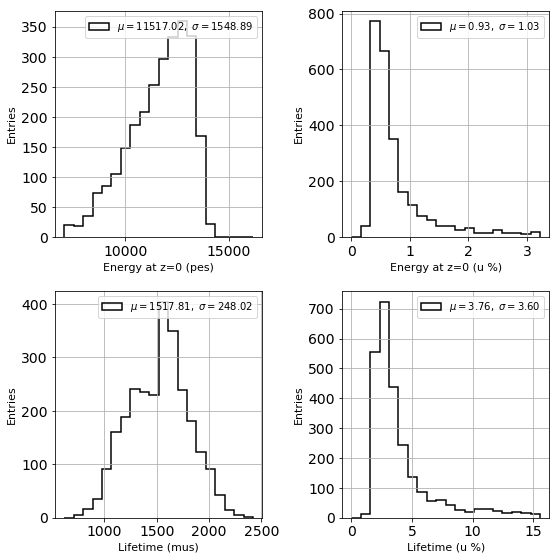

In [61]:
krh.h1d_4((Escale.value[valid],Escale.uncertainty[valid],
          ELT.value[valid],ELT.uncertainty[valid]),
          (20,20,20,20),
          (kltl.Es.interval,kltl.Eu.interval,kltl.LT.interval,kltl.LTu.interval),
          ('Energy at z=0 (pes)','Energy at z=0 (u %)','Lifetime (mus)', 'Lifetime (u %)'),
          ('Entries','Entries','Entries','Entries'),
          titles  =None,
          legends = ('best','best','best','best'),
          figsize =(8,8))


Average lifetime             (mean +- rms) = ((16.9 +- 2.8) · 1e2) µs
Average lifetime uncertainty (mean +- rms) = (3.26 +- 0.75) (%)


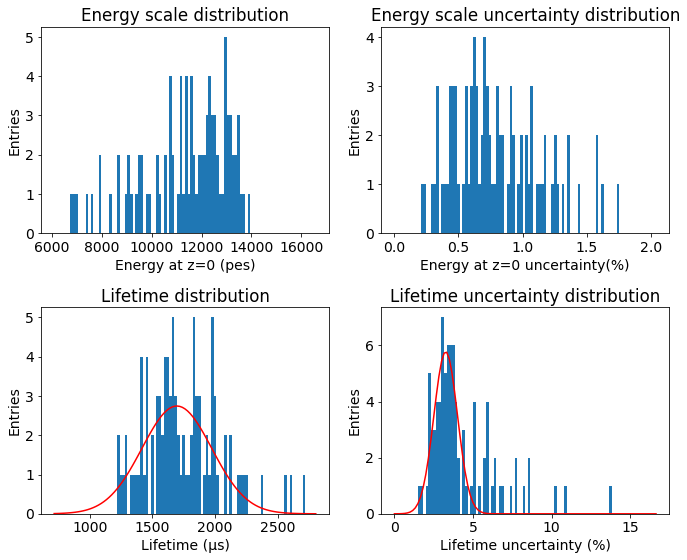

In [379]:
plt.subplot(2, 2, 1)
bins    = np.linspace(E_min, E_max, 101)
y, x, _ = plt.hist(Escale.value[valid].flatten(), bins)
labels("Energy at z=0 (pes)", "Entries", "Energy scale distribution")

plt.subplot(2, 2, 2)
bins    = np.linspace(Eu_min, Eu_max, 101)
y, x, _ = plt.hist(Escale.uncertainty[valid].flatten(), bins)
labels("Energy at z=0 uncertainty(%)", "Entries", "Energy scale uncertainty distribution")

plt.subplot(2, 2, 3)
bins    = np.linspace(ELT_min, ELT_max, 101)
y, x, _ = plt.hist       (ELT.value[valid].flatten(), bins)
f       = quick_gauss_fit(ELT.value[valid].flatten(), bins)
plt.plot(x, f.fn(x), "r-")
labels("Lifetime (µs)", "Entries", "Lifetime distribution")

plt.subplot(2, 2, 4)
bins    = np.linspace(ELTu_min, ELTu_max, 101)
y, x, _ = plt.hist       (ELT.uncertainty[valid].flatten(), bins)
fu      = quick_gauss_fit(ELT.uncertainty[valid].flatten(), bins)
plt.plot(x, fu.fn(x), "r-")
labels("Lifetime uncertainty (%)", "Entries", "Lifetime uncertainty distribution")

plt.tight_layout()


print("Average lifetime             (mean +- rms) = ({}) µs" .format(measurement_string(f .values[1], f .values[2])))
print("Average lifetime uncertainty (mean +- rms) = ({}) (%)".format(measurement_string(fu.values[1], fu.values[2])))

/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 30 but corresponding boolean dimension is 60
  This is separate from the ipykernel package so we can avoid doing imports until


IndexError: index 30 is out of bounds for axis 0 with size 30

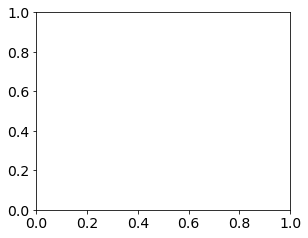

In [273]:
plt.subplot(2, 2, 1)
bins    = np.linspace(Q_min, Q_max, 101)
y, x, _ = plt.hist(Qscale.value[Eok].flatten(), bins)
labels("Charge at z=0 (pes)", "Entries", "Charge scale distribution")

plt.subplot(2, 2, 2)
bins    = np.linspace(Qu_min, Qu_max, 101)
y, x, _ = plt.hist(Qscale.uncertainty[Eok].flatten(), bins)
labels("Charge at z=0 uncertainty(%)", "Entries", "Charge scale uncertainty distribution")

plt.subplot(2, 2, 3)
bins    = np.linspace(QLT_min, QLT_max, 101)
y, x, _ = plt.hist       (QLT.value[Eok].flatten(), bins)
f       = quick_gauss_fit(QLT.value[Eok].flatten(), bins)
plt.plot(x, f.fn(x), "r-")
labels("Charge lifetime (µs)", "Entries", "Charge lifetime distribution")

plt.subplot(2, 2, 4)
bins    = np.linspace(QLTu_min, QLTu_max, 101)
y, x, _ = plt.hist       (QLT.uncertainty[Eok].flatten(), bins)
fu      = quick_gauss_fit(QLT.uncertainty[Eok].flatten(), bins)
plt.plot(x, fu.fn(x), "r-")
labels("Charge lifetime uncertainty (%)", "Entries", "Charge lifetime uncertainty distribution")

plt.tight_layout()


print("Average lifetime             (mean +- rms) = ({}) µs" .format(measurement_string(f .values[1], f .values[2])))
print("Average lifetime uncertainty (mean +- rms) = ({}) (%)".format(measurement_string(fu.values[1], fu.values[2])))

In [62]:
invalid = ~valid

In [36]:
def display_lifetime_maps(Escale : Measurement, ELT: Measurement, kltl : KrLTLimits, 
                          mask : np.array):

    #fig = plt.figure(figsize=figsize)
    #fig.add_subplot(2, 2, 1)
    plt.subplot(2, 2, 1)
    *_, cb = display_matrix(XYcenters, XYcenters, Escale.value, mask,
                            vmin = kltl.Es.min,
                            vmax = kltl.Es.max,
                            cmap = default_cmap,
                            new_figure = False);
    cb.set_label("Energy scale at z=0 (pes)")
    labels("X (mm)", "Y (mm)", "Energy scale")

    #fig.add_subplot(2, 2, 2)
    plt.subplot(2, 2, 2)
    *_, cb = display_matrix(XYcenters, XYcenters, Escale.uncertainty, mask,
                        vmin = kltl.Eu.min,
                        vmax = kltl.Eu.max,
                        cmap = default_cmap,
                        new_figure = False);
    cb.set_label("Relative energy scale uncertainty (%)")
    labels("X (mm)", "Y (mm)", "Relative energy scale uncertainty")

    #fig.add_subplot(2, 2, 3)
    plt.subplot(2, 2, 3)
    *_, cb = display_matrix(XYcenters, XYcenters, ELT.value, mask=valid,
                        vmin = kltl.LT.min,
                        vmax = kltl.LT.max,
                        cmap = default_cmap,
                        new_figure = False);
    cb.set_label("Lifetime (µs)")
    labels("X (mm)", "Y (mm)", "Lifetime")

    #fig.add_subplot(2, 2, 4)
    plt.subplot(2, 2, 4)
    *_, cb = display_matrix(XYcenters, XYcenters, ELT.uncertainty, mask=valid,
                        vmin = kltl.LTu.min,
                        vmax = kltl.LTu.max,
                        cmap = default_cmap,
                        new_figure = False);
    cb.set_label("Relative lifetime uncertainty (%)")
    labels("X (mm)", "Y (mm)", "Relative lifetime uncertainty")

    plt.tight_layout()


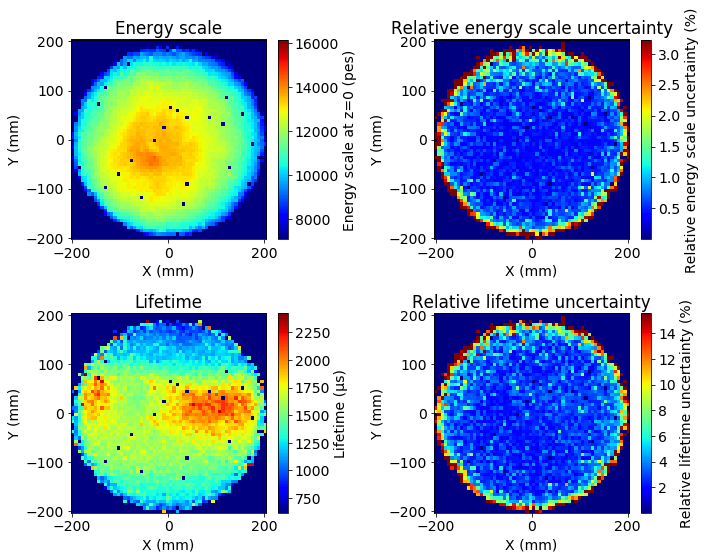

In [63]:
display_lifetime_maps(Escale, ELT, kltl, valid)
                         

(1.221575754760118, 0.54371787057636412)

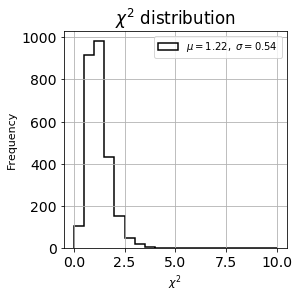

In [64]:
krh.h1d(Echi2[valid], bins=20, range=(0,10), xlabel="$\chi^2$", ylabel='Frequency',
        title="$\chi^2$ distribution", legend = 'upper right', figsize=(4,4))

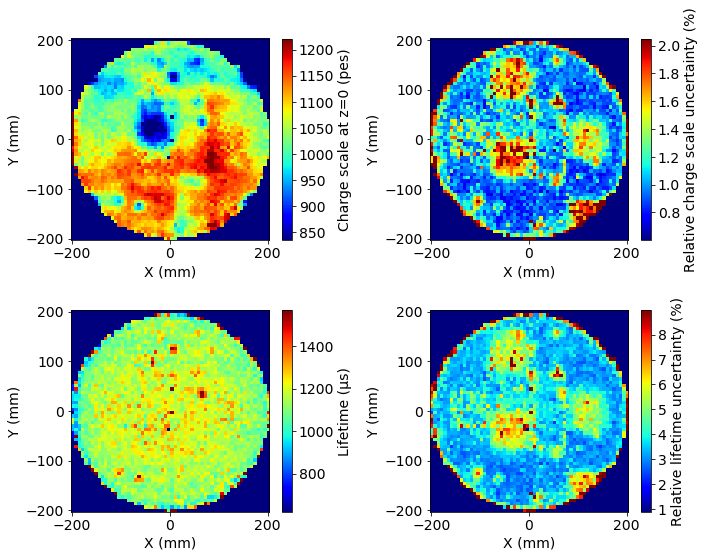

In [31]:
plt.subplot(2, 2, 1)
*_, cb = display_matrix(XYcenters, XYcenters, Qscale.value,
                        vmin = Q_min,
                        vmax = Q_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Charge scale at z=0 (pes)")
labels("X (mm)", "Y (mm)", "Charge scale")

plt.subplot(2, 2, 2)
*_, cb = display_matrix(XYcenters, XYcenters, Qscale.uncertainty,
                        vmin = Qu_min,
                        vmax = Qu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative charge scale uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative charge scale uncertainty")

plt.subplot(2, 2, 3)
*_, cb = display_matrix(XYcenters, XYcenters, QLT.value,
                        vmin = QLT_min,
                        vmax = QLT_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime")

plt.subplot(2, 2, 4)
*_, cb = display_matrix(XYcenters, XYcenters, QLT.uncertainty,
                        vmin = QLTu_min,
                        vmax = QLTu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative lifetime uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative lifetime uncertainty")

plt.tight_layout()
save("Lifetime_and_charge_scale_maps")

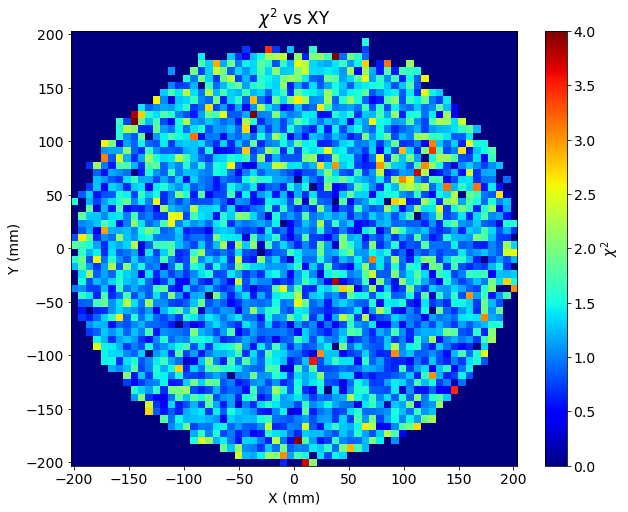

In [65]:
#plt.subplot(1, 1, 1)
*_, cb = display_matrix(XYcenters, XYcenters, Echi2, mask=valid,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

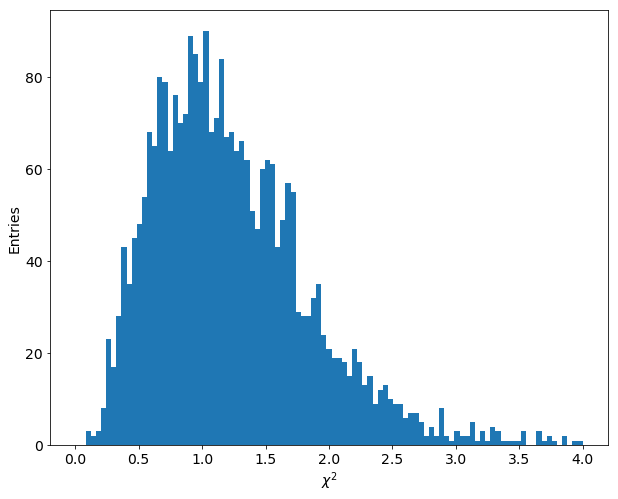

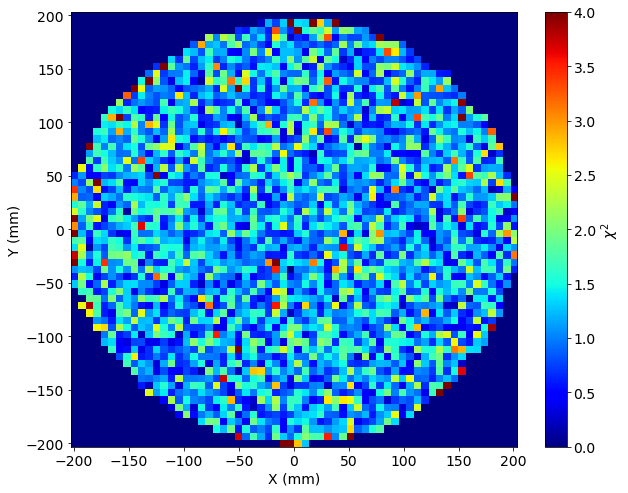

In [33]:
plt.hist(Qchi2[Qchi2 > 0], np.linspace(0, 4, 100))
labels("$\chi^2$", "Entries", "$\chi^2$ distribution")

*_, cb = display_matrix(XYcenters, XYcenters, Qchi2,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

### Fix map

- Fill bins where fit has failed with average value of lifetime

In [66]:
Escl   = np.where(valid, Escale_abs.value      ,     Es.mu)
Escl_u = np.where(valid, Escale_abs.uncertainty,     Es.mu_u * Es.mu / 100 )

Elt     = np.where(valid,   ELT_abs.value      , El.mu)
Elt_u   = np.where(valid,ELT_abs.uncertainty,    El.mu_u * El.mu / 100 )

In [67]:
Escale = Measurement(np.where(valid, Escale_abs.value      ,     Es.mu), 
                    np.where(valid, Escale_abs.uncertainty,     Es.mu_u * Es.mu / 100 ))

ELT = Measurement(np.where(valid,   ELT_abs.value      , El.mu), 
                    np.where(valid,ELT_abs.uncertainty,    El.mu_u * El.mu / 100))

In [68]:
eu = minmax(kltl.Eu.min * Es.mu / 100,  kltl.Eu.max *  Es.mu / 100)
ltu = minmax(kltl.LTu.min * El.mu / 100,  kltl.LTu.max *  El.mu / 100)
KL = KrLTLimits(kltl.Es, kltl.LT, eu, ltu)

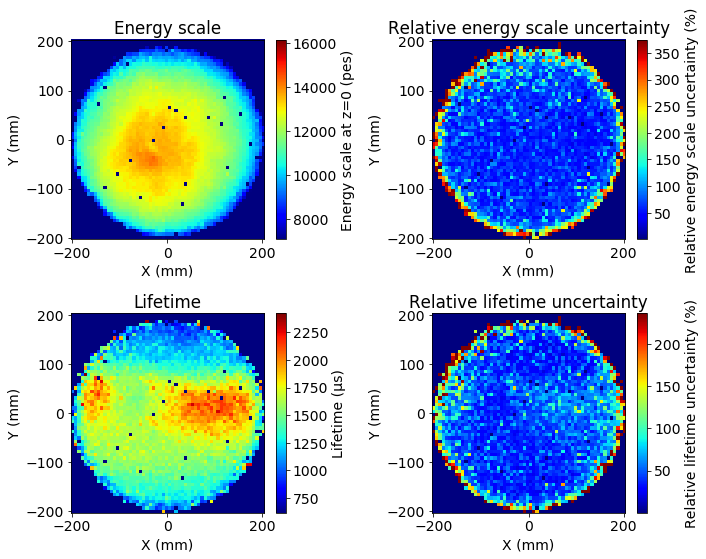

In [69]:
display_lifetime_maps(Escale, ELT, KL, valid)

### Produce HDF5 output

In [447]:
with tb.open_file(output_dst_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Escl, Escl_u, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = XYpitch

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, Elt, Elt_u, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = XYpitch



In [34]:
# This is to avoid the effect of low stat bins
# to the map. Data points in that bin could be
# loss or corrected with an unrealistic lifetime.
# Thus, we assign the average value. This works
# because correcting with a slightly different
# lifetime does not have a big impact on energy
# resolution.

Escale_safe  = np.where(Eok, Escale_abs.value      ,     E_mean)
Escaleu_safe = np.where(Eok, Escale_abs.uncertainty,    Eu_mean *   E_mean / 100)

ELT_safe     = np.where(Eok,   ELT_abs.value      , ELT_mean)
ELTu_safe    = np.where(Eok,ELT_abs.uncertainty,    ELTu_mean * ELT_mean / 100)

Qscale_safe  = np.where(Qok, Qscale_abs.value      ,     Q_mean)
Qscaleu_safe = np.where(Qok, Qscale_abs.uncertainty,    Qu_mean *   Q_mean / 100)

QLT_safe     = np.where(Qok,   QLT_abs.value      ,  QLT_mean)
QLTu_safe    = np.where(Qok,   QLT_abs.uncertainty, QLTu_mean * QLT_mean / 100)

with tb.open_file(correction_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Escale_safe, Escaleu_safe, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = XYpitch

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, ELT_safe, ELTu_safe, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = XYpitch

    write_qscale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Qscale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Qscale_safe, Qscaleu_safe, nevt)
    correction_file.root.XYcorrections.Qscale.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Qscale.attrs.xy_pitch = XYpitch

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "QLifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, QLT_safe, QLTu_safe, nevt)
    correction_file.root.XYcorrections.QLifetime.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.QLifetime.attrs.xy_pitch = XYpitch